### Data preparation after CD-HIT

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
from torch.utils.data import (TensorDataset, DataLoader, RandomSampler,
                              SequentialSampler)
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import numpy as np
import os
import torch.nn.functional as F
import torch.optim as optim
import sys
import pandas as pd
import re
from torch.utils.data import (TensorDataset, DataLoader, RandomSampler,
                              SequentialSampler)

In [2]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


#### Read files after CD-HIT as pandas df, and add a label "is_enzyme"

***Enzymes***

In [3]:
df_enzyme = pd.read_csv("/Users/marharyta/Desktop/Data_science/IT_Academy/Exam_project/data/after_cd_hit/enzyme.csv", names = ["Enzyme_class","Sequence", "Artifact"], sep=";", engine= "python")

In [4]:
df_enzyme.drop("Artifact", axis= 1, inplace= True)
df_enzyme["Is_enzyme"] = 1

In [5]:
df_enzyme[['Sequence', "Is_enzyme"]]

,Sequence,Is_enzyme
0,ATAQEQPEGEAPDKVESPVVXXXEAXIVLVNYAREADVDAMMKDAV...,1
1,MATTSIAGPRLTSLKTAAGKLGYREICHVRQWAPVHSPMPHFGMLR...,1
2,MHPYFSLAGRIALVTGGSRGIGQMIAQGLLEAGARVFICARDAEAC...,1
3,MHYLPVAIVTGATRGIGKAICQKLFQKGLSCIILGSTKESIERTAI...,1
4,MKTTKKIAVITGANRGLGKGIAEELSNTNNITVIGTSTSQKGCKII...,1
...,...,...
22118,MSSLVSTPFTTATGVQKKLGAPVPLHSFLLSRRQPAAGAGRGRAAA...,1
22119,MTPTAQTTASARRVVFPFTAIVGQEEMKLALLLNVIDPKIGGVMIM...,1
22120,MHLLLAQKGTIADGNEAIDLGQTPADILFLSAADTELSSIAAAHGR...,1
22121,MMSKIDLDISNLPDTTISVREVFGIDTDLRVPAYSKGDAYVPDLDP...,1


In [6]:
df_enzyme.head()

,Enzyme_class,Sequence,Is_enzyme
0,1.1.1.100,ATAQEQPEGEAPDKVESPVVXXXEAXIVLVNYAREADVDAMMKDAV...,1
1,1.1.1.100,MATTSIAGPRLTSLKTAAGKLGYREICHVRQWAPVHSPMPHFGMLR...,1
2,1.1.1.100,MHPYFSLAGRIALVTGGSRGIGQMIAQGLLEAGARVFICARDAEAC...,1
3,1.1.1.100,MHYLPVAIVTGATRGIGKAICQKLFQKGLSCIILGSTKESIERTAI...,1
4,1.1.1.100,MKTTKKIAVITGANRGLGKGIAEELSNTNNITVIGTSTSQKGCKII...,1


***Not enzymes***

In [7]:
df_non_enzyme = pd.read_csv("/Users/marharyta/Desktop/Data_science/IT_Academy/Exam_project/data/after_cd_hit/non_enzyme.csv", names = ["Sequence", "Artifact"])

In [8]:

df_non_enzyme.drop("Artifact", axis= 1, inplace= True)
df_non_enzyme["Is_enzyme"] = 0

In [9]:
df_non_enzyme.head()

,Sequence,Is_enzyme
0,MNQQLSWRTIVGYSLGDVANNFAFAMGALFLLSYYTDVAGVGAAAA...,0
1,HGLPAQCPNADGTMVHTCCLHGMPTFKLNFDSHFTIKTVVAQNGTE...,0
2,MTWLLLCLLAQYENGGKVLALSSSAKPYKTSVRFDPKTAHPNLVVS...,0
3,MALPLPPASNLHSILLVTKSRSLGPRLVFHYPPLSPSAAALAGAKD...,0
4,MATEIGSPPRFFHMPRFQHQAPRQLFYKRPDFAQQQAMQQLTFDGK...,0


In [10]:
# concatenate 2 dfs together in df
df = pd.concat([df_enzyme[['Sequence', "Is_enzyme"]], df_non_enzyme], axis=0)

In [11]:
#longest protein entry
df.Sequence.map(lambda x: len(x)).max()

4998

In [12]:
df = df[df['Sequence'].str.len() < 500]

In [13]:
len(df)

31659

In [14]:
len_max_seq = (df.Sequence.map(lambda x: len(x)).max()) +1

In [15]:
len_max_seq

500

### ***Some EDA***

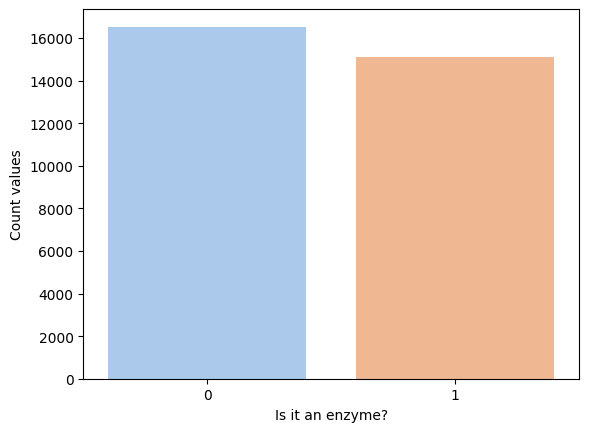

In [16]:
# main classes are represented equally
sns.set_palette("pastel")
ax = sns.barplot(x=df.Is_enzyme.value_counts().index, y=df.Is_enzyme.value_counts())
ax.set(xlabel='Is it an enzyme?', ylabel='Count values');

### Data preparation for training

***Encoding of amino acids***

In [17]:
only_sequences = df.Sequence.tolist()

In [18]:
len(only_sequences)

31659

In [19]:
from numpy import argmax
# define input string
# define universe of possible input values
aa_code = 'ABCDEFGHIKLMNOPQRSTUVWYXZ'
vocab_size_aa = len(aa_code)+1
# define a mapping of chars to integers
char_to_int = dict((c, i) for i, c in enumerate(aa_code, start = 1))
int_to_char = dict((i, c) for i, c in enumerate(aa_code, start = 1))
# integer encode input data
encoded_aa = list()
for val in only_sequences:
 integer_encoded = [char_to_int[char] for char in val]
 encoded_aa.append(integer_encoded)


***Padding***

In [20]:
padding = 0

In [21]:
for protein in encoded_aa:
 if len(protein) < len_max_seq:
  for i in range (len_max_seq-len(protein)):
   protein.append(padding)

In [22]:
len(encoded_aa[1])

500

In [23]:
# combine the data to new df
df_X = pd.DataFrame(encoded_aa)

***Create dataset after padding***

In [24]:
df.reset_index(drop = True, inplace=True)
df_ready = pd.concat([df_X, df[['Is_enzyme']]], axis = 1)

In [25]:
df_ready.tail()

,0,1,2,3,4,5,6,7,8,9,...,491,492,493,494,495,496,497,498,499,Is_enzyme
31654,12,9,23,10,18,9,1,5,17,11,...,0,0,0,0,0,0,0,0,0,0
31655,12,11,19,17,6,11,7,15,17,23,...,0,0,0,0,0,0,0,0,0,0
31656,12,18,15,10,15,17,1,18,7,15,...,0,0,0,0,0,0,0,0,0,0
31657,12,15,9,10,10,11,9,18,10,9,...,0,0,0,0,0,0,0,0,0,0
31658,12,21,11,9,19,17,23,11,15,18,...,0,0,0,0,0,0,0,0,0,0


***Train-test split***

In [26]:
# Import libraries
#import lazypredict
#from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef

# Load dataset
X = df_ready.drop('Is_enzyme', axis = 1)
y = df_ready['Is_enzyme'].copy()

# Data split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state =42, stratify=y)


In [27]:
# Build random forest model

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=500)

rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=500)

In [28]:
# Simplest and quickest way to obtain the model performance (Accuracy)
rf.score(X_test,y_test)

0.649557801642451

***Torch section***

In [29]:
def data_loader(train_inputs, test_inputs, train_labels, test_labels,
                batch_size=50):
    """
    Convert train and validation sets to torch.Tensors and load them to
    DataLoader.
    """

    # Convert data type to torch.Tensor
    train_inputs, test_inputs, train_labels, test_labels =\
    tuple(torch.tensor(data.values) for data in
          [train_inputs, test_inputs, train_labels, test_labels])

    # Create DataLoader for training data
    train_data = TensorDataset(train_inputs, train_labels)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

    # Create DataLoader for validation data
    test_data = TensorDataset(test_inputs, test_labels)
    test_sampler = SequentialSampler(test_data)
    test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

    return train_dataloader, test_dataloader

In [30]:
train_dataloader, test_dataloader = data_loader(X_train, X_test, y_train, y_test)

***CNN Architecture*** (from https://chriskhanhtran.github.io/posts/cnn-sentence-classification/)
![CNN Architecture](cnn-architecture.JPG)


In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN_NLP(nn.Module):
    """An 1D Convulational Neural Network for Sentence Classification."""
    def __init__(self,
                 pretrained_embedding=None,
                 freeze_embedding=False,
                 vocab_size=None,
                 embed_dim=300,
                 filter_sizes=[3, 4, 5],
                 num_filters=[100, 100, 100],
                 num_classes=2,
                 dropout=0.5):
        """
        The constructor for CNN_NLP class.

        Args:
            pretrained_embedding (torch.Tensor): Pretrained embeddings with
                shape (vocab_size, embed_dim)
            freeze_embedding (bool): Set to False to fine-tune pretraiend
                vectors. Default: False
            vocab_size (int): Need to be specified when not pretrained word
                embeddings are not used.
            embed_dim (int): Dimension of word vectors. Need to be specified
                when pretrained word embeddings are not used. Default: 300
            filter_sizes (List[int]): List of filter sizes. Default: [3, 4, 5]
            num_filters (List[int]): List of number of filters, has the same
                length as `filter_sizes`. Default: [100, 100, 100]
            n_classes (int): Number of classes. Default: 2
            dropout (float): Dropout rate. Default: 0.5
        """

        super(CNN_NLP, self).__init__()
        # Embedding layer
        if pretrained_embedding is not None:
            self.vocab_size, self.embed_dim = pretrained_embedding.shape
            self.embedding = nn.Embedding.from_pretrained(pretrained_embedding,
                                                          freeze=freeze_embedding)
        else:
            self.embed_dim = embed_dim
            self.embedding = nn.Embedding(num_embeddings=vocab_size,
                                          embedding_dim=self.embed_dim,
                                          padding_idx=0,
                                          max_norm=5.0)
        # Conv Network
        self.conv1d_list = nn.ModuleList([
            nn.Conv1d(in_channels=self.embed_dim,
                      out_channels=num_filters[i],
                      kernel_size=filter_sizes[i])
            for i in range(len(filter_sizes))
        ])
        # Fully-connected layer and Dropout
        self.fc = nn.Linear(np.sum(num_filters), num_classes)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, input_ids):
        """Perform a forward pass through the network.

        Args:
            input_ids (torch.Tensor): A tensor of token ids with shape
                (batch_size, max_sent_length)

        Returns:
            logits (torch.Tensor): Output logits with shape (batch_size,
                n_classes)
        """

        # Get embeddings from `input_ids`. Output shape: (b, max_len, embed_dim)
        x_embed = self.embedding(input_ids).float()

        # Permute `x_embed` to match input shape requirement of `nn.Conv1d`.
        # Output shape: (b, embed_dim, max_len)
        x_reshaped = x_embed.permute(0, 2, 1)

        # Apply CNN and ReLU. Output shape: (b, num_filters[i], L_out)
        x_conv_list = [F.relu(conv1d(x_reshaped)) for conv1d in self.conv1d_list]

        # Max pooling. Output shape: (b, num_filters[i], 1)
        x_pool_list = [F.max_pool1d(x_conv, kernel_size=x_conv.shape[2])
            for x_conv in x_conv_list]

        # Concatenate x_pool_list to feed the fully connected layer.
        # Output shape: (b, sum(num_filters))
        x_fc = torch.cat([x_pool.squeeze(dim=2) for x_pool in x_pool_list],
                         dim=1)

        # Compute logits. Output shape: (b, n_classes)
        logits = self.fc(self.dropout(x_fc))

        return logits

In [32]:
import torch.optim as optim

def initilize_model(pretrained_embedding=None,
                    freeze_embedding=False,
                    vocab_size=None,
                    embed_dim=300,
                    filter_sizes=[3, 4, 5],
                    num_filters=[100, 100, 100],
                    num_classes=2,
                    dropout=0.5,
                    learning_rate=0.01):
    """Instantiate a CNN model and an optimizer."""

    assert (len(filter_sizes) == len(num_filters)), "filter_sizes and \
    num_filters need to be of the same length."

    # Instantiate CNN model
    cnn_model = CNN_NLP(pretrained_embedding=pretrained_embedding,
                        freeze_embedding=freeze_embedding,
                        vocab_size=vocab_size,
                        embed_dim=embed_dim,
                        filter_sizes=filter_sizes,
                        num_filters=num_filters,
                        num_classes=2,
                        dropout=0.5)

    # Send model to `device` (GPU/CPU)
    cnn_model.to(device)

    # Instantiate Adadelta optimizer
    optimizer = optim.Adadelta(cnn_model.parameters(),
                               lr=learning_rate,
                               rho=0.95)

    return cnn_model, optimizer

In [33]:
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility."""

    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, optimizer, train_dataloader, val_dataloader=None, epochs=10):
    """Train the CNN model."""

    # Tracking best validation accuracy
    best_accuracy = 0

    # Start training loop
    print("Start training...\n")
    print(f"{'Epoch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
    print("-"*60)

    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================

        # Tracking time and loss
        t0_epoch = time.time()
        total_loss = 0

        # Put the model into the training mode
        model.train()

        for step, batch in enumerate(train_dataloader):
            # Load batch to GPU
            b_input_ids, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Update parameters
            optimizer.step()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        # =======================================
        #               Evaluation
        # =======================================
        if val_dataloader is not None:
            # After the completion of each training epoch, measure the model's
            # performance on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Track the best accuracy
            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            print(f"{epoch_i + 1:^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")

    print("\n")
    print(f"Training complete! Best accuracy: {best_accuracy:.2f}%.")

def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's
    performance on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled
    # during the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [34]:
# CNN-rand: Word vectors are randomly initialized.
set_seed(42)
cnn_rand, optimizer = initilize_model(vocab_size=vocab_size_aa,
                                      embed_dim=50,
                                      learning_rate=0.2,
                                      dropout=0.5)


In [35]:
train(cnn_rand, optimizer, train_dataloader, test_dataloader, epochs=20)

Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |   0.682189   |  0.594615  |   73.38   |  210.64  
   2    |   0.614608   |  0.552455  |   74.54   |  212.44  
   3    |   0.576847   |  0.557972  |   71.13   |  219.37  
   4    |   0.554552   |  0.585979  |   69.19   |  211.72  
   5    |   0.540948   |  0.515002  |   75.46   |  215.40  
   6    |   0.529136   |  0.543359  |   71.49   |  215.67  
   7    |   0.523054   |  0.502198  |   76.40   |  215.27  
   8    |   0.514452   |  0.526776  |   74.72   |  214.62  
   9    |   0.506812   |  0.526802  |   74.57   |  217.12  
  10    |   0.501494   |  0.522210  |   73.67   |  215.05  
  11    |   0.496607   |  0.485687  |   77.42   |  212.62  
  12    |   0.490085   |  0.489284  |   77.20   |  209.81  
  13    |   0.483010   |  0.495126  |   76.13   |  209.65  
  14    |   0.477942   |  0.484611  |   77.34   |  210.73  
  15    |   0.477448

In [36]:
#Makes a predict based on the aa sequence"
import torch
import torch.nn.functional as F

def predict(seq, model, max_len = 500):
    """Predict probability that a protein sequence is an enzyme."""
    model.to("cpu")
    # Tokenize, pad and encode text
    aa_code = 'ABCDEFGHIKLMNOPQRSTUVWYXZ'
    char_to_int = dict((c, i) for i, c in enumerate(aa_code, start=1))
    encoded_seq = [char_to_int[char] for char in seq]

    padding = 0
    if len(seq) < max_len:
        for i in range(max_len + 1 - len(seq)):
            encoded_seq.append(padding)

    # Convert to PyTorch tensors
    input_id = torch.tensor(encoded_seq).unsqueeze(dim=0)

    # Compute logits
    logits = model.forward(input_id)

    #  Compute probability
    probs = F.softmax(logits, dim=1).squeeze(dim=0)
    probs_detached = probs.detach().numpy()


    return probs_detached

In [38]:
sequence = "MAPYPYKVQTTVPELQYENFDGAKFGYMFWPVQNGTNEVRGRVLLIHGFGEYTKIQFRLMDHLSLNGYESFTFDQRGAGVTSPGRSKGVTDEYHVFNDLEHFVEKNLSECKAKGIPLFMWGHSMGGGICLNYACQGKHKNEISGYIGSGPLIILHPHTMYNKPTQIIAPLLAKFLPRVRIDTGLDLKGITSDKAYRAFLGSDPMSVPLYGSFRQIHDFMQRGAKLYKNENNYIQKNFAKDKPVIIMHGQDDTINDPKGSEKFIQDCPSADKELKLYPGARHSIFSLETDKVFNTVFNDMKQWLDKHTTTEAKP"

In [39]:
predict(sequence, model= cnn_rand)

array([0.06117718, 0.9388228 ], dtype=float32)

***Save model***

In [40]:
torch.save(cnn_rand.state_dict(), 'model.pt')

***Inference***

In [41]:
from model import cnn_model
model, optimizer = cnn_model.initilize_model(vocab_size=26,
                                      embed_dim=50,
                                      learning_rate=0.2,
                                      dropout=0.5)

No GPU available, using the CPU instead.


In [42]:
model.load_state_dict(torch.load("../model/model.pt"))
model.eval()

CNN_NLP(
  (embedding): Embedding(26, 50, padding_idx=0, max_norm=5.0)
  (conv1d_list): ModuleList(
    (0): Conv1d(50, 100, kernel_size=(3,), stride=(1,))
    (1): Conv1d(50, 100, kernel_size=(4,), stride=(1,))
    (2): Conv1d(50, 100, kernel_size=(5,), stride=(1,))
  )
  (fc): Linear(in_features=300, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [43]:
sequence_enzyme = "MKFVKRRIIALVTILMLSVTSLFALQPSAKAAEHNPVVMVHGIGGASFNFAGIKSYLVSQGWSRDKLYAVDFWDKTGTNYNNGPVLSRFVQKVLDETGAKKVDIVAHSMGGANTLYYIKNLDGGNKVANVVTLGGANRLTTGKALPGTDPNQKILYTSIYSSADMIVMNYLSRLDGARNVQIHGVGHIGLLYSSQVNSLIKEGLNGGGQNTN"

In [44]:
from app import preprocessing_and_predict
probs = preprocessing_and_predict.predict(sequence_enzyme, model=model)

In [46]:
f"This sequence is {probs[1] * 100:.2f}% an enzyme."

'This sequence is 85.86% an enzyme.'